In [1]:
#The libraries that we will be using
import qiskit_nature
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
qiskit_nature.settings.use_pauli_sum_op = False
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit import Aer, execute
from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA
import time
from qiskit.exceptions import QiskitError

In [2]:
# Defining the molecular information including atomic symbols, coordinates, multiplicity, and charge
molecule = MoleculeInfo(
    # Coordinates in Angstrom
    symbols=["H", "H"],  # Atomic symbols of the two hydrogen atoms
    coords=([0.0, 0.0, -0.3625], [0.0, 0.0, 0.3625]),  # Coordinates of the two hydrogen atoms
    multiplicity=1,  # Multiplicity of the molecule (1 for singlet)
    charge=0,  # Charge of the molecule (neutral charge)
)

# Create a PySCF driver to compute the molecular integrals
driver = PySCFDriver.from_molecule(molecule)

# Run the driver to obtain the electronic structure problem
problem = driver.run()

# Extract the second quantized operators representing the Hamiltonian
second_q_ops = problem.second_q_ops()

# Get the number of spatial orbitals and the number of particles in the system
num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles

# We are using ParityMapper to map the electronic structure problem to qubits, 
mapper = ParityMapper(num_particles=num_particles)


hamiltonian = second_q_ops[0]

# Performing two-qubit reduction
qubit_op = mapper.map(hamiltonian)
print(qubit_op)


SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.05016043+0.j,  0.40421466+0.j, -0.40421466+0.j, -0.01134688+0.j,
  0.18037525+0.j])


In [3]:
repulsion_energy = problem.nuclear_repulsion_energy# we will use this later to adjust the total energy
print(repulsion_energy)

0.7298996012689656


In [9]:
def exact_solver(qubit_op, problem):
    """
    Solves the quantum problem exactly using the NumPyMinimumEigensolver that will be
    used as reference for the results of the custom VQE

    Args:
        qubit_op (WeightedPauliOperator): The qubit operator representing the quantum problem.
        problem (ElectronicStructureProblem): The electronic structure problem containing
                                              information about the molecule and the Hamiltonian.

    Returns:
        dict: A dictionary containing the result of the exact solver.

    Raises:
        AlgorithmError: If an error occurs during the computation.
    """
    # Use NumPyMinimumEigensolver to compute the minimum eigenvalue
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    if sol is None:
        raise ValueError("Solver did not find a valid solution.")
    
    result = problem.interpret(sol)
    return result

In [11]:
result = exact_solver(qubit_op, problem)
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.867120978341
  - computed part:      -1.867120978341
~ Nuclear repulsion energy (Hartree): 0.729899601269
> Total ground state energy (Hartree): -1.137221377072
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.0]
 


In [12]:
E_FCI = result.total_energies[0].real
print(E_FCI)

-1.1372213770723023


In [13]:
def random_circuit_ansatz(num_qubits, depth, include_two_qubit_gates=True):
    """
    Generate a random quantum circuit ansatz.

    Args:
        num_qubits (int): The number of qubits in the circuit.
        depth (int): The depth of the circuit, i.e., the number of layers of gates.
        include_two_qubit_gates (bool): If True, include two-qubit gates in the circuit.

    Returns:
        QuantumCircuit: A randomly generated quantum circuit ansatz.

    Notes:
        This function generates a random quantum circuit ansatz with the specified number
        of qubits and depth. The circuit can include single-qubit gates (Hadamard, RX, RY, and RZ),
        and optionally, two-qubit gates (CX gates).

        The circuit is parameterized using Parameter objects, allowing for later optimization
        of the circuit's parameters.

        If include_two_qubit_gates is True, the function randomly adds CX gates between pairs
        of qubits with a 50% probability.

        The generated quantum circuit is returned for further use in VQE or other quantum algorithms.
    """
    circuit = QuantumCircuit(num_qubits)

    # Create parameter objects for the circuit parameters
    circuit_params = [[Parameter(f"theta_{d}_{q}") for q in range(num_qubits)] for d in range(depth)]

    for d in range(depth):
        for q in range(num_qubits):
            rand_gate = np.random.choice(['h', 'rx', 'ry', 'rz'])
            rand_param = circuit_params[d][q]  # Get the corresponding parameter object

            if rand_gate == 'h':
                circuit.h(q)
            elif rand_gate == 'rx':
                circuit.rx(rand_param, q)
            elif rand_gate == 'ry':
                circuit.ry(rand_param, q)
            elif rand_gate == 'rz':
                circuit.rz(rand_param, q)
        if include_two_qubit_gates:
            for qubit1 in range(num_qubits - 1):
                for qubit2 in range(qubit1 + 1, num_qubits):
                    if np.random.rand() < 0.5:
                        circuit.cx(qubit1, qubit2)

    return circuit

In [15]:
# Example usage:
num_qubits = 3  # Number of qubits in the circuit
depth = 5  # Depth of the circuit

ansatz_circuit = random_circuit_ansatz(num_qubits, depth, include_two_qubit_gates=True)
print("Ansatz Circuit:")
print(ansatz_circuit)
print("Number of parameters: ")
print(ansatz_circuit.num_parameters)
print("\nAnsatz Parameters:")
print(ansatz_circuit.parameters)

Ansatz Circuit:
     ┌───────────────┐          ┌───────────────┐                 »
q_0: ┤ Rx(theta_0_0) ├──■────■──┤ Rz(theta_1_0) ├────────■────────»
     └─────┬───┬─────┘┌─┴─┐  │  └─────┬───┬─────┘      ┌─┴─┐      »
q_1: ──────┤ H ├──────┤ X ├──┼────────┤ H ├────────────┤ X ├──────»
     ┌─────┴───┴─────┐└───┘┌─┴─┐┌─────┴───┴─────┐┌─────┴───┴─────┐»
q_2: ┤ Ry(theta_0_2) ├─────┤ X ├┤ Rz(theta_1_2) ├┤ Rx(theta_2_2) ├»
     └───────────────┘     └───┘└───────────────┘└───────────────┘»
«           ┌───┐                ┌───────────────┐                 ┌───┐     »
«q_0: ──────┤ H ├────────■────■──┤ Rz(theta_3_0) ├────────■────────┤ H ├──■──»
«     ┌─────┴───┴─────┐┌─┴─┐  │  └─────┬───┬─────┘      ┌─┴─┐      ├───┤┌─┴─┐»
«q_1: ┤ Rx(theta_2_1) ├┤ X ├──┼────────┤ H ├────────────┤ X ├──────┤ H ├┤ X ├»
«     └───────────────┘└───┘┌─┴─┐┌─────┴───┴─────┐┌─────┴───┴─────┐└───┘└───┘»
«q_2: ──────────────────────┤ X ├┤ Rz(theta_3_2) ├┤ Rz(theta_4_2) ├──────────»
«                           └───┘└

In [16]:
# Helper function to assign parameters to the circuit 
def assign_parameters(circuit, params):
    # Get the list of circuit parameters
    circuit_params = circuit.parameters
    
    # Check if the number of circuit parameters matches the number of elements in params
    if len(circuit_params) != len(params):
        raise ValueError("Number of circuit parameters does not match the length of the input array.")
    
    # Assign the parameters to the circuit by binding them
    for param, value in zip(circuit_params, params):
        circuit.bind_parameters({param: value})
    
    return circuit

In [17]:
# Function to generate random parameters in specified bounds
def random_params(num_params):
    # Define the range for the random parameters (e.g., 0 to 2*pi)
    lower_bound = 0
    upper_bound = 2 * np.pi
    
    # Generate random parameters using uniform distribution
    params = np.random.uniform(lower_bound, upper_bound, num_params)
    
    return params

In [18]:
init_params = random_params(ansatz_circuit.num_parameters)
print(init_params)

[4.66212555 0.93104689 4.66631141 0.23587908 1.09744462 5.13877155
 6.16193874 1.49150662 4.36622221]


In [19]:
def calculate_expectation(circuit, params, hamiltonian):
    """
    Calculate the expectation value of a quantum circuit with respect to a given Hamiltonian.

    Args:
        circuit (QuantumCircuit): The quantum circuit to evaluate.
        params (numpy.ndarray): An array of parameter values to bind to the circuit.
        hamiltonian matrix : The Hamiltonian operator.

    Returns:
        float: The expectation value of the circuit with respect to the Hamiltonian.

    Notes:
        This function calculates the expectation value of a quantum circuit with respect to
        a given Hamiltonian. The circuit is parameterized using Parameter objects, and the
        provided parameter values are bound to the circuit before evaluation.

        The function simulates the quantum circuit on the statevector simulator backend
        and computes the expectation value using the statevector representation of the circuit's
        final state. The expectation value is calculated as the inner product between the
        statevector and the Hamiltonian operator.

        The function returns the total expected energy.

    Raises:
        QiskitError: If the circuit evaluation job fails or the Hamiltonian is invalid.
    """
    backend = Aer.get_backend('statevector_simulator')

    # Bind the provided parameter values to the circuit
    bound_circuit = circuit.bind_parameters({p: val for p, val in zip(circuit.parameters, params.flatten())})

    try:
        # Execute the bound circuit on the statevector simulator backend
        job = execute(bound_circuit, backend)
        result = job.result()
        statevector = result.get_statevector()
    except Exception as exc:
        raise QiskitError("Failed to evaluate the circuit on the statevector simulator!") from exc

    # Calculate the expectation value as the inner product between statevector and Hamiltonian
    expectation = np.vdot(statevector, np.dot(hamiltonian, statevector))
    return expectation.real


In [20]:
Hamiltonian_matrix = qubit_op.to_matrix()
print(Hamiltonian_matrix)

[[-1.06150732+0.j  0.        +0.j  0.        +0.j  0.18037525+0.j]
 [ 0.        +0.j -1.84724287+0.j  0.18037525+0.j  0.        +0.j]
 [ 0.        +0.j  0.18037525+0.j -0.23038423+0.j  0.        +0.j]
 [ 0.18037525+0.j  0.        +0.j  0.        +0.j -1.06150732+0.j]]


In [21]:
def my_vqe(ansatz_circuit, qubit_op, max_iterations=100, tolerance=1e-4):
    """
    Perform the Variational Quantum Eigensolver (VQE) algorithm to find the ground state energy
    of a given Hamiltonian using a parameterized quantum circuit (ansatz).

    Args:
        ansatz_circuit (QuantumCircuit): The parameterized quantum circuit (ansatz) to prepare the quantum state.
        qubit_op (PauliSumOp | SparsePauliOp | BaseOperator): The Hamiltonian as a qubit operator for which
            the ground state energy is to be calculated.
        max_iterations (int, optional): The maximum number of iterations for the optimizer (default is 100).
        tolerance (float, optional): The convergence tolerance for the optimizer (default is 1e-4).

    Returns:
        tuple: A tuple containing the following elements:
            - numpy.ndarray: The optimal parameters for the ansatz circuit.
            - float: The final ground state energy obtained after VQE optimization.
            - float: The time taken for the VQE optimization.

    Note:
        The objective function of the COBYLA optimizer is defined internally to update the circuit,
        print intermediate energies in steps of 5, and return the intermediate energy during optimization.

    Example:
        num_qubits = 4
        depth = 3
        ansatz_circuit = random_circuit_ansatz(num_qubits, depth)
        params, final_energy, optimizer_time = my_vqe(ansatz_circuit, hamiltonian)
        print(f"Optimal parameters: {params}")
        print(f"Final ground state energy: {final_energy}")
        print(f"Optimizer time: {optimizer_time} seconds")
    """
    
    #Random initialization of the circuit parameters
    num_params = len(ansatz_circuit.parameters)
    params = random_params(num_params)
    circuit = assign_parameters(ansatz_circuit, params)
    hamiltonian = qubit_op.to_matrix()
    
    previous_energy = float('inf')

    optimizer = COBYLA(maxiter=max_iterations, tol=tolerance)

    # The objective function for the optimizer
    eval_count = 0
    def objective_function(p):
        nonlocal eval_count
        updated_circuit = assign_parameters(ansatz_circuit, p)
        intermediate_energy = calculate_expectation(updated_circuit, p, hamiltonian)
        eval_count += 1
        if eval_count%5 == 0:
            print(f"Iteration {eval_count}: Energy = {intermediate_energy}")
        return intermediate_energy

    start_time = time.time()
    result = optimizer.minimize(objective_function, x0=params)
    end_time = time.time()

    optimal_params = result.x
    final_energy = calculate_expectation(ansatz_circuit, optimal_params, hamiltonian)
    optimizer_time = end_time - start_time

    return params, final_energy, optimizer_time


In [51]:
depths = np.arange(1, 30, 1)
times = []
vqe_energies = []
for dep in depths:
    var_form =  random_circuit_ansatz(qubit_op.num_qubits,dep, False)#No 2 qubit gates
    optimal_params, final_energy, total_time = my_vqe(var_form, qubit_op)
    vqe_result = final_energy + repulsion_energy #Adding the shift
    vqe_energies.append(vqe_result)
    times.append(total_time)
    print(
        f"Depth: {np.round(dep, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Time: {total_time:.3f} seconds",
    )

Iteration 5: Energy = -1.4927246431947125
Iteration 10: Energy = -1.492793291082245
Iteration 15: Energy = -1.4927935683691342
Iteration 20: Energy = -1.492794279616169
Depth: 1 VQE Result: -0.76289 Time: 0.261 seconds
Iteration 5: Energy = -1.8395601417248408
Iteration 10: Energy = -1.802850042660767
Iteration 15: Energy = -1.846553418374337
Iteration 20: Energy = -1.8469712885317064
Iteration 25: Energy = -1.8471748576273246
Iteration 30: Energy = -1.8472296876955752
Iteration 35: Energy = -1.8472426147408616
Iteration 40: Energy = -1.8472428085426937
Iteration 45: Energy = -1.8472428358118353
Iteration 50: Energy = -1.8472428700823447
Depth: 2 VQE Result: -1.11734 Time: 0.880 seconds
Iteration 5: Energy = -1.360406207916335
Iteration 10: Energy = -1.4105584120989931
Iteration 15: Energy = -1.4450426361930093
Iteration 20: Energy = -1.4517078911513015
Iteration 25: Energy = -1.4475490579631298
Iteration 30: Energy = -1.4543693385566865
Iteration 35: Energy = -1.4541321194939574
Itera

Accuracy: Depth(without_2-qubit_gates) vs VQE Result


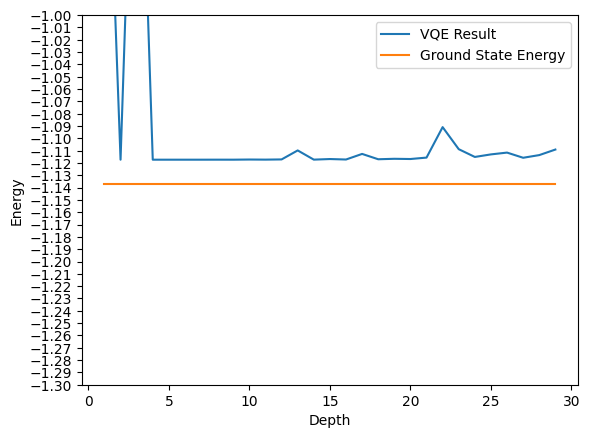

In [52]:
print("Accuracy: Depth(without_2-qubit_gates) vs VQE Result")
plt.plot(depths, vqe_energies, label="VQE Result")
plt.plot(depths, [E_FCI] * len(depths), label="Ground State Energy")
plt.xlabel("Depth")
plt.ylabel("Energy")
plt.legend()

# Set y-axis range from -1.3 to -1 and add ticks at steps of 0.01
plt.ylim(-1.3, -1)
y_ticks = [i * 0.01 for i in range(-130, -99)]  # Assuming a range of -1.3 to -1
plt.yticks(y_ticks)

plt.show()

In [53]:
print(vqe_energies)

[-0.7628946754156367, -1.1173432626860322, -0.7244754922625396, -1.1173432681276712, -1.11734326828502, -1.1173432639992478, -1.117342996639821, -1.1173275144954202, -1.1173385419930233, -1.117211994894713, -1.1172928319811695, -1.1171275647364651, -1.1098297555072263, -1.1172952028886665, -1.11681895193495, -1.117201323798539, -1.1126589955806787, -1.1169911868618552, -1.1166180594932185, -1.1167988977921413, -1.1156421077126355, -1.090911103374072, -1.10881320167744, -1.1151172210079512, -1.1130480956760007, -1.1115836047718184, -1.115783049351352, -1.1136176316636341, -1.1091195862025036]


Depth(without_2-qubit_gates) vs Time


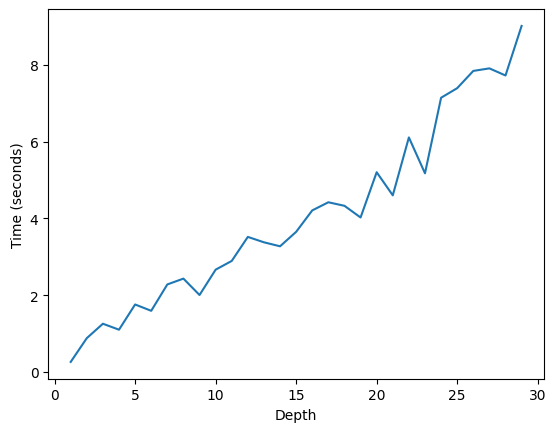

In [55]:
print("Depth(without_2-qubit_gates) vs Time")
plt.plot(depths, times, label="Time")
plt.xlabel("Depth")
plt.ylabel("Time (seconds)")
plt.show()

In [56]:
depths_2 = np.arange(1, 30, 1)
times_2 = []
vqe_energies_2 = []
for dep in depths_2:
    var_form =  random_circuit_ansatz(qubit_op.num_qubits,dep, True)#setting inclusion of two-qubit gates to true
    print(var_form)
    optimal_params, final_energy, total_time = my_vqe(var_form, qubit_op)
    vqe_result = final_energy + repulsion_energy #Adding the shift
    vqe_energies_2.append(vqe_result)
    times_2.append(total_time)
    print(
        f"Depth: {np.round(dep, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Time: {total_time:.3f} seconds",
    )

     ┌───────────────┐
q_0: ┤ Rx(theta_0_0) ├
     ├───────────────┤
q_1: ┤ Rz(theta_0_1) ├
     └───────────────┘
Iteration 5: Energy = -1.6616174680911744
Iteration 10: Energy = -1.8433920670523667
Iteration 15: Energy = -1.8470571163878418
Iteration 20: Energy = -1.8472406491887916
Iteration 25: Energy = -1.847242825068587
Iteration 30: Energy = -1.8472428680354906
Depth: 1 VQE Result: -1.11734 Time: 0.499 seconds
     ┌───┐     ┌───────────────┐
q_0: ┤ H ├──■──┤ Ry(theta_1_0) ├
     ├───┤┌─┴─┐├───────────────┤
q_1: ┤ H ├┤ X ├┤ Rx(theta_1_1) ├
     └───┘└───┘└───────────────┘
Iteration 5: Energy = -1.1343835354082425
Iteration 10: Energy = -1.4916403923640105
Iteration 15: Energy = -1.4927810031165254
Iteration 20: Energy = -1.492794278740467
Iteration 25: Energy = -1.4927940533159196
Iteration 30: Energy = -1.4927942754083037
Depth: 2 VQE Result: -0.76289 Time: 0.668 seconds
     ┌───────────────┐     ┌───────────────┐┌───────────────┐
q_0: ┤ Rx(theta_0_0) ├──■──┤ Rx(theta_1_0) ├┤ 

In [57]:
print(vqe_energies)

[-0.7628946754156367, -1.1173432626860322, -0.7244754922625396, -1.1173432681276712, -1.11734326828502, -1.1173432639992478, -1.117342996639821, -1.1173275144954202, -1.1173385419930233, -1.117211994894713, -1.1172928319811695, -1.1171275647364651, -1.1098297555072263, -1.1172952028886665, -1.11681895193495, -1.117201323798539, -1.1126589955806787, -1.1169911868618552, -1.1166180594932185, -1.1167988977921413, -1.1156421077126355, -1.090911103374072, -1.10881320167744, -1.1151172210079512, -1.1130480956760007, -1.1115836047718184, -1.115783049351352, -1.1136176316636341, -1.1091195862025036]


Accuracy: Depth(with_random_2-qubit_gates) vs VQE Result


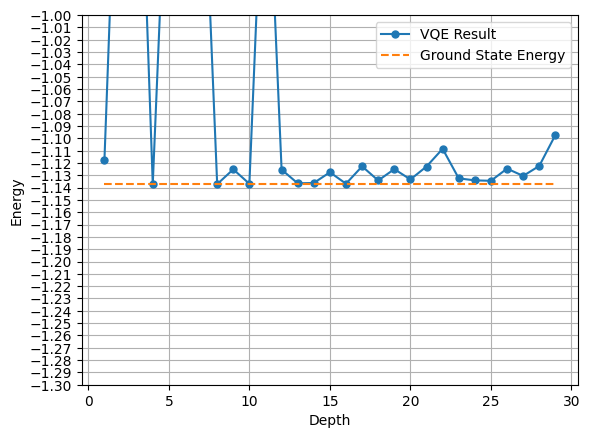

In [58]:
print("Accuracy: Depth(with_random_2-qubit_gates) vs VQE Result")
plt.plot(depths_2, vqe_energies_2, 'o-', label="VQE Result", markersize=5)
plt.plot(depths_2, [E_FCI] * len(depths_2), '--', label="Ground State Energy")
plt.xlabel("Depth")
plt.ylabel("Energy")
plt.legend()

# Set y-axis range from -1.3 to -1 and add ticks at steps of 0.01
plt.ylim(-1.3, -1)
y_ticks = [round(-1.3 + i * 0.01, 2) for i in range(31)]  # Assuming a range of -1.3 to -1
plt.yticks(y_ticks)

plt.grid()  # Add grid lines for better visibility of data points
plt.show()

Depth(with_random_2-qubit_gates) vs Time


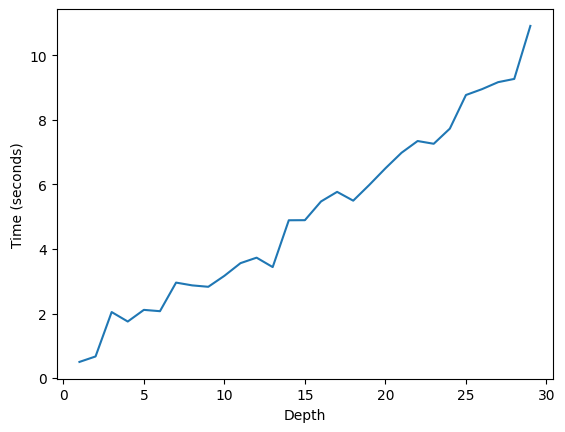

In [76]:
print("Depth(with_random_2-qubit_gates) vs Time")
plt.plot(depths_2, times_2, label="Time")
plt.xlabel("Depth")
plt.ylabel("Time (seconds)")
plt.show()

In [72]:
# Now lets see the results using EfficientSU2 and the VQE algorithm from the Qiskit Library
# We will also make use of Estimator to calculate the expectation value
from qiskit_aer.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.circuit.library import EfficientSU2

depths_3 = np.arange(1, 30, 1)
times_3 = []
vqe_energies_3 = []
noiseless_estimator = Estimator(approximation=True)
optimizer = COBYLA(maxiter=100, tol = 1e-4)
for dep in depths_3:
    var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear", reps = dep)
    start_time = time.time()
    vqe = VQE(noiseless_estimator, var_form, optimizer)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    end_time = time.time()
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_3.append(vqe_result)
    total_time = end_time - start_time
    times_3.append(total_time)
    print(f"Depth {dep}: VQE_Result = {vqe_result}: Time {total_time}")

Depth 1: VQE_Result = -1.137123465265965: Time 2.2768075466156006
Depth 2: VQE_Result = -1.1370809584064667: Time 1.8607871532440186
Depth 3: VQE_Result = -1.136912444884124: Time 1.9399523735046387
Depth 4: VQE_Result = -1.1360833877720744: Time 2.2570765018463135
Depth 5: VQE_Result = -1.1327335377216623: Time 2.139834403991699
Depth 6: VQE_Result = -1.1343599015879062: Time 2.0303666591644287
Depth 7: VQE_Result = -1.1354035906852071: Time 2.1700868606567383
Depth 8: VQE_Result = -1.133011158580347: Time 2.55000901222229
Depth 9: VQE_Result = -1.1269588529395678: Time 2.588108539581299
Depth 10: VQE_Result = -1.1206687832890632: Time 2.631394386291504
Depth 11: VQE_Result = -1.129340103931882: Time 2.625883102416992
Depth 12: VQE_Result = -1.1287170754007765: Time 2.8477516174316406
Depth 13: VQE_Result = -1.129297693109103: Time 2.469724416732788
Depth 14: VQE_Result = -1.1231818254979278: Time 2.7233705520629883
Depth 15: VQE_Result = -1.1132611253647766: Time 3.2909016609191895
D

In [73]:
print(vqe_energies_3)

[-1.137123465265965, -1.1370809584064667, -1.136912444884124, -1.1360833877720744, -1.1327335377216623, -1.1343599015879062, -1.1354035906852071, -1.133011158580347, -1.1269588529395678, -1.1206687832890632, -1.129340103931882, -1.1287170754007765, -1.129297693109103, -1.1231818254979278, -1.1132611253647766, -1.1114926115575428, -1.10766359069209, -1.128224053345279, -1.0883501698881157, -1.088637120791937, -1.08971427549391, -1.1015833507050896, -1.111145610419048, -1.0981720931956804, -1.111589531784372, -1.068795134356819, -1.088979517658986, -1.0583538411828257, -1.1064182789664156]


Accuracy: Depth(EfficientSU2) vs VQE Result


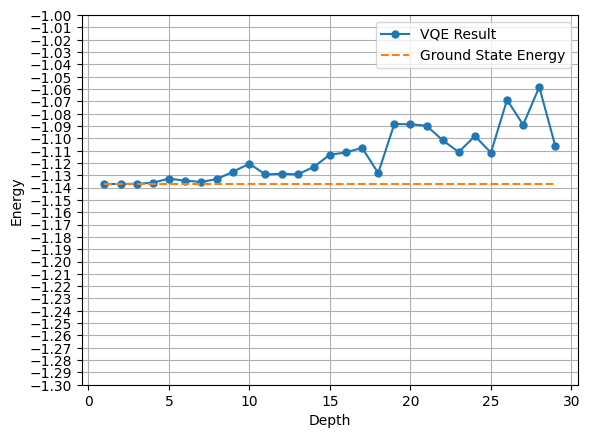

In [75]:
print("Accuracy: Depth(EfficientSU2) vs VQE Result")
plt.plot(depths_3, vqe_energies_3, 'o-', label="VQE Result", markersize=5)
plt.plot(depths_3, [E_FCI] * len(depths_3), '--', label="Ground State Energy")
plt.xlabel("Depth")
plt.ylabel("Energy")
plt.legend()

# Set y-axis range from -1.3 to -1 and add ticks at steps of 0.01
plt.ylim(-1.3, -1)
y_ticks = [round(-1.3 + i * 0.01, 2) for i in range(31)]  # Assuming a range of -1.3 to -1
plt.yticks(y_ticks)

plt.grid()  # Add grid lines for better visibility of data points
plt.show()

Depth(EfficientSU2) vs Time


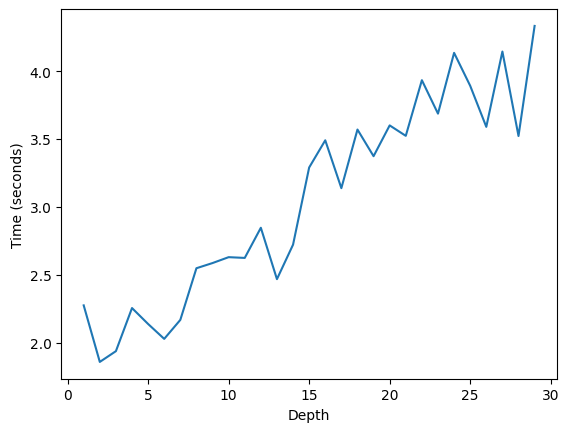

In [77]:
print("Depth(EfficientSU2) vs Time")
plt.plot(depths_3, times_3, label="Time")
plt.xlabel("Depth")
plt.ylabel("Time (seconds)")
plt.show()

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table